In [1]:
import numpy as np
import pydensecrf.densecrf as dcrf
from skimage.io import imread, imsave
from skimage.transform import resize
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
%matplotlib inline

In [2]:
def decode(PredictionString):
    mask = PredictionString.split()
    img = np.zeros(256*256, dtype=np.uint8)
    for i, m, in enumerate(mask):
        img[i] = int(m)
    return img.reshape(256,256)

def encode(im):
    pixels = im.flatten()
    return ' '.join(str(x) for x in pixels)

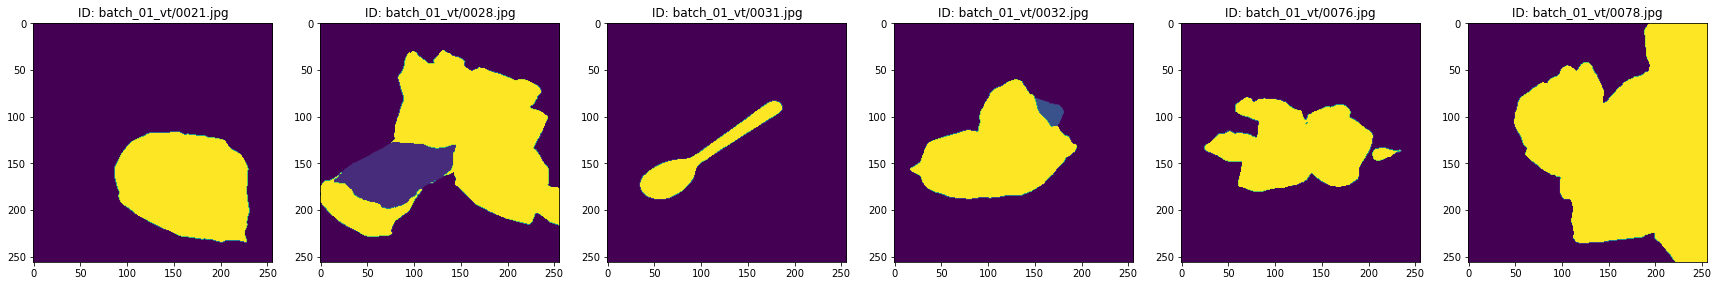

In [3]:
"""
reading and decoding the submission 

"""
df = pd.read_csv('./ensemble_latest.csv')
i = 0
j = 0
plt.figure(figsize=(30,15))
plt.subplots_adjust(bottom=0.2, top=0.8, hspace=0.2)  #adjust this to change vertical and horiz. spacings..
# Visualizing the predicted outputs
while True:
    if str(df.loc[i,'PredictionString'])!=str(np.nan):        
        decoded_mask = decode(df.loc[i,'PredictionString'])
        plt.subplot(1,6,j+1)
        plt.imshow(decoded_mask)
        plt.title('ID: '+df.loc[i,'image_id'])
        j = j + 1
        if j>5:
            break
    i = i + 1

In [27]:
"""
Function which returns the labelled image after applying CRF

"""
#Original_image = Image which has to labelled
#Mask image = Which has been labelled by some technique..
def crf(original_image, mask_img):
    
    labels = mask_img.flatten()

    # print(len(labels))
    n_labels = 11
    
    #Setting up the CRF model
    d = dcrf.DenseCRF2D(256, 256, n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=3, compat=3, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    # This adds the color-dependent term, i.e. features are (x,y,r,g,b).
    d.addPairwiseBilateral(sxy=30, srgb=7, rgbim=original_image, compat=5)
    
    Q = d.inference(45)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((256, 256))

In [28]:
test_path = '../input/data/'

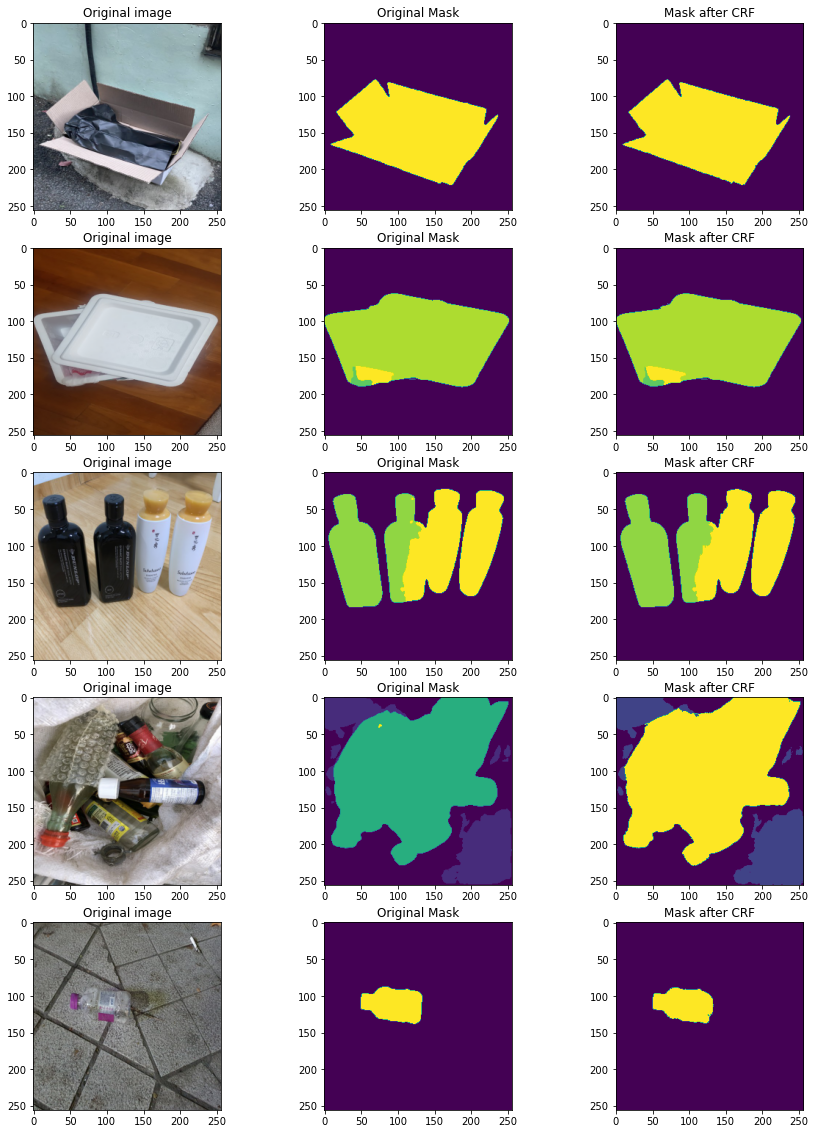

In [29]:
"""
visualizing the effect of applying CRF

"""
nImgs = 5
i = 500
j = 1
plt.figure(figsize=(20,20))
plt.subplots_adjust(wspace=0.2,hspace=0.2)  #adjust this to change vertical and horiz. spacings..
while True:
    if str(df.loc[i,'PredictionString'])!=str(np.nan):        
        decoded_mask = decode(df.loc[i,'PredictionString'])        
        orig_img = imread(test_path+df.loc[i,'image_id'])
        orig_img = resize(orig_img, (256, 256, 3))
        orig_img = np.uint8(255 * orig_img)
        #Applying CRF on FCN-16 annotated image
        crf_output = crf(orig_img,decoded_mask)
        plt.subplot(nImgs,4,4*j-3)
        plt.imshow(orig_img)
        plt.title('Original image')
        plt.subplot(nImgs,4,4*j-2)
        plt.imshow(decoded_mask) 
        plt.title('Original Mask')
        plt.subplot(nImgs,4,4*j-1)
        plt.imshow(crf_output) 
        plt.title('Mask after CRF')
        if j == nImgs:
            break
        else:
            j = j + 1
    i = i + 1

In [156]:
"""
Applying CRF on the predicted mask 

"""
for i in tqdm(range(df.shape[0])):
    if str(df.loc[i,'PredictionString'])!=str(np.nan):        
        decoded_mask = decode(df.loc[i,'PredictionString'])        
        orig_img = imread(test_path+df.loc[i,'image_id'])
        orig_img = resize(orig_img, (256, 256, 3))
        orig_img = np.uint8(255 * orig_img)
        crf_output = crf(orig_img,decoded_mask)
        df.loc[i,'PredictionString'] = encode(crf_output)

100%|██████████| 819/819 [19:19<00:00,  1.42s/it]


In [157]:
df.to_csv('crf_correction.csv',index=False)